In [46]:
#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as pl
%matplotlib inline
import imageio
from scipy.interpolate import interp1d

#Edge Detection
import skimage
import skimage.feature
import skimage.viewer
import sys
from skimage.data import camera
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h

**Step One: Edge Detection**

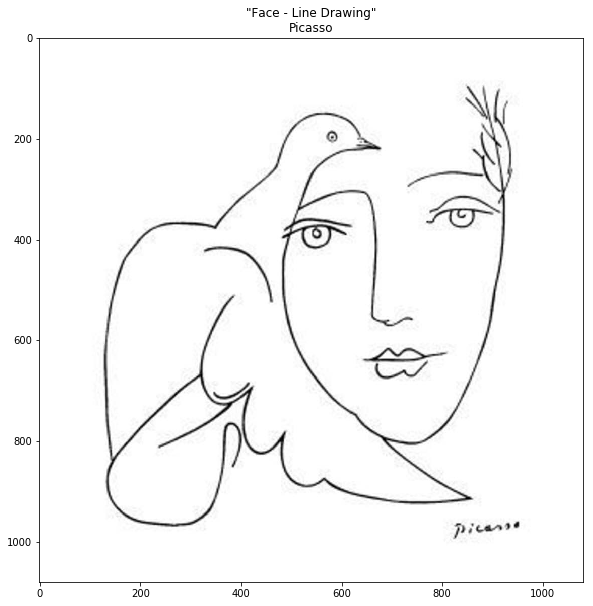

In [47]:
face = imageio.imread('Paintings/Face_Picasso.jpg')
plt.figure(figsize = (10,10))
plt.title('"Face - Line Drawing"\nPicasso')
plt.imshow(face)

In [48]:
#Ok, let's convert the grayscale to a simple black-white: that may help us in observing the 
#"Fractal" structure (and other formal qualities)

def bw_convert(img,thresh):
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    
    return bw_pic

#Ok, let's write a formula that can convert from color to bw/binary image
def make_bw(img,thresh=130):
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img

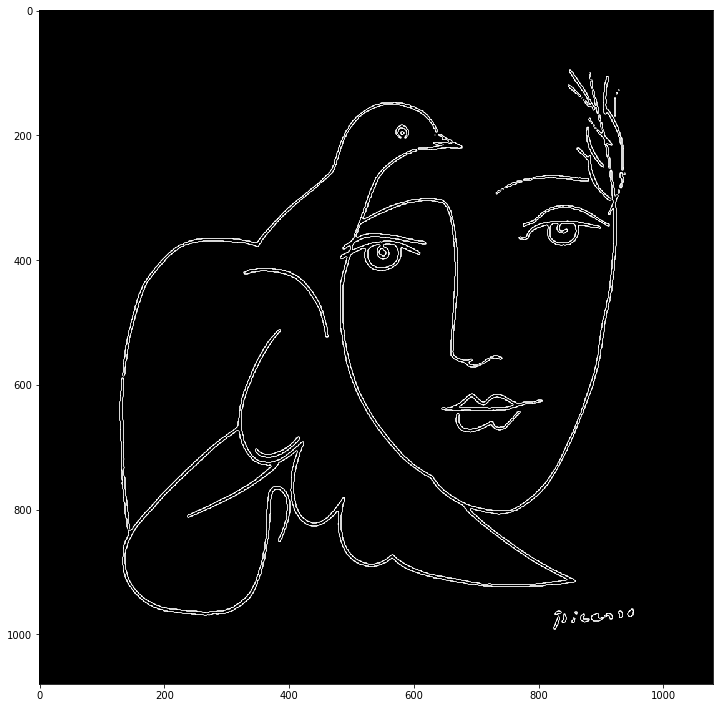

In [49]:
bw_face = make_bw(face,130)
face_edge = scharr(bw_face)
plt.figure(figsize = (10,10))
plt.imshow(face_edge, cmap=plt.cm.gray)
plt.tight_layout()
plt.show()

Now that we have an edge detector, let's write a formula that can decomose this matrix into two vectors: the x and y values of all non-zero points.

In [50]:
def line_vectors(edge_image):
    row_vals = []
    col_vals = []
    for i in range(len(edge_image)):
        for j in range(len(edge_image[i])):
            if edge_image[i][j]>0:
                row_vals.append(i)
                col_vals.append(j)
    
    return list(reversed(col_vals)),row_vals

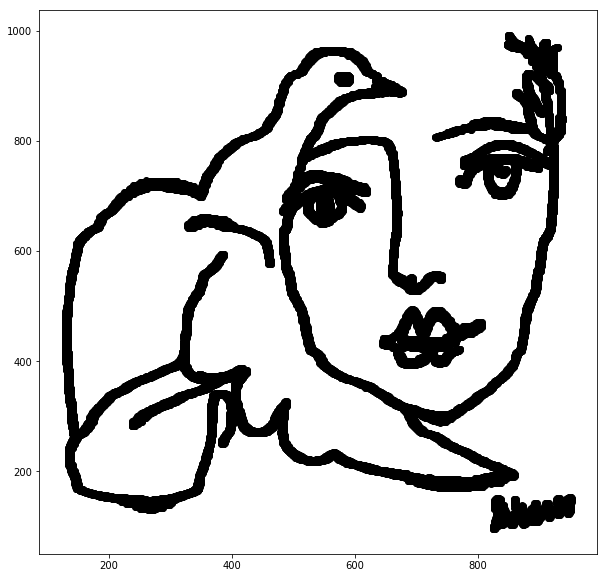

In [51]:
x_vals, y_vals = line_vectors(face_edge)
plt.figure(figsize = (10,10))
plt.scatter(x_vals,y_vals,color='k')
plt.show()

Now, let's create a whole new vector - this one a list of index values, such that every x/y pair will have a unique index value.

In [52]:
index_vals = []
index_val = 0
for i in x_vals:
    index_vals.append(index_val)
    index_val += 1
    
#And let's stitch this all up into a single dataframe
val_df = pd.DataFrame({
    'index':index_vals,
    'x_vals':x_vals,
    'y_vals':y_vals})

What do the above arrays look like, plotted relative to the index array?

Text(0.5,1,'X Values vs. Index')

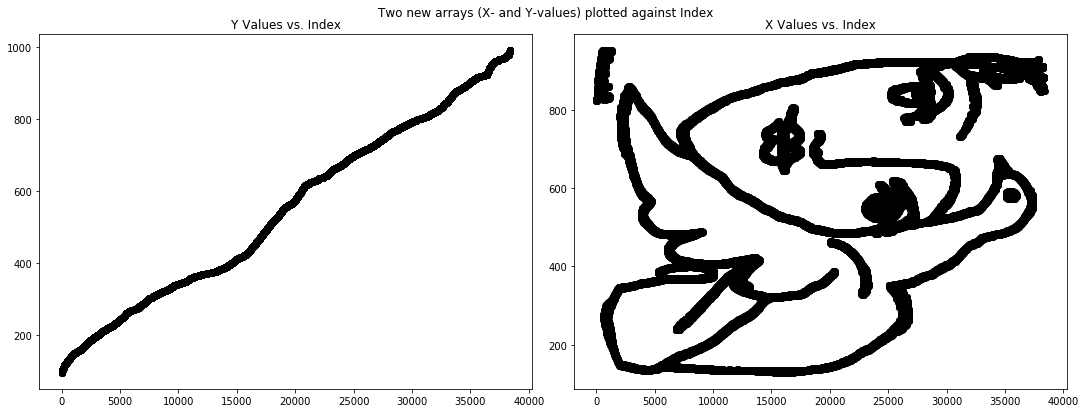

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,6))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Two new arrays (X- and Y-values) plotted against Index")

ax1.scatter(index_vals,y_vals,color='k')
ax1.set_title("Y Values vs. Index")
ax2.scatter(index_vals,x_vals,color='k')
ax2.set_title("X Values vs. Index")

Decomposing each image into a vector of xs and ys results in two arrays, each of each has no duplicate x/y pairs. While it's hard to tell from this image, the "X-Values" image on the right actually consists of lots of little dots/lines of dots, each of which is unique to each index value: there is only one Y-value (or in this case "X-value") for every index value. 

This obviates the problem we had before: of how to interplolate an image with multiple y values for every x value. 

We can now begin interpolating. What we will do is create a series of interpolating functions for the index/y pairs, and another set of interpolating functions for the index/x pairs. We will then plot these two sets of interpolating functions against each other. 

**Interpolation**

Our first step in interpolating will be to break up all of the little continuous line segments in the image on the right above (of X-Values plotted against Index) into discrete segments which we can then interpolate separately. 

In [54]:
def array_break(orig_array,thresh=2):
    index_arrays = []
    index_array = [0]
    ind = 0

    sub_arrays = []
    sub_array = [orig_array[0]]
    for i in orig_array[1:len(orig_array)]:
        ind += 1
        if np.abs(i - sub_array[-1])<3: ####
            sub_array.append(i)
            index_array.append(ind)

        else: 
            if len(sub_array)>thresh: #This is somewhat arbitrary: we just ignore sub-arrays that are smaller than the 
                #...abitrary threshold value; this reduces the complexity somewhat
                sub_arrays.append(sub_array)
                index_arrays.append(index_array)

                sub_array = []
                sub_array.append(i)

                index_array = []
                index_array.append(ind)
            else: #I.e., if the array is shorter than 2, then don't bother adding it
                sub_array = []
                sub_array.append(i)

                index_array = []
                index_array.append(ind)
                
    if len(sub_arrays)<1: ###
        return [index_array],[sub_array] ###
    else:
        return index_arrays,sub_arrays
    

In [55]:
def gen_interp_funs(index_arrays,sub_arrays):
    interp_funs = [] #This will be an array of separate interpolation functions
    for i in range(len(sub_arrays)):
        if len(sub_arrays[i])<4: #i.e., if the array is smaller than 3, just use linear interpolation
            f_i = interp1d(index_arrays[i], sub_arrays[i],fill_value="extrapolate")
            interp_funs.append(f_i)

        else:
            f_i = interp1d(index_arrays[i], sub_arrays[i], kind='cubic',fill_value="extrapolate")
            interp_funs.append(f_i)
    
    return interp_funs

In [56]:
def gen_interp_vals(interp_funs,index_arrays):
    calc_vals = []
    for i in range(len(index_arrays)):
        fun_iter = interp_funs[i]
        calc_val_list = [fun_iter(index_arrays[i])]
        calc_vals.append(calc_val_list)

    #Now let's stitch this all up into a single array
    calc_val_array = []
    for i in calc_vals:
        for j in i[0]:
            calc_val_array.append(j)

    index_val_array = []
    for i in index_arrays:
        for j in i:
            index_val_array.append(j)
    
    return index_val_array,calc_val_array

Now let's write a single function to automate the entire process: input a line image, and get back values of x's, y's, and interpolating functions for each. 

In [97]:
def interp_image(img):
    bw_img = make_bw(img,130)
    img_edge = scharr(bw_img)
    x_vals, y_vals = line_vectors(img_edge)
    
    index_vals = []
    index_val = 0
    for i in x_vals:
        index_vals.append(index_val)
        index_val += 1
    
    index_arrays,sub_arrays = array_break(x_vals)
    interp_funs = gen_interp_funs(index_arrays,sub_arrays)
    x_inds,xs = gen_interp_vals(interp_funs,index_arrays)
    
    index_arrays,sub_arrays = array_break(y_vals)
    interp_funs = gen_interp_funs(index_arrays,sub_arrays)
    y_inds,ys = gen_interp_vals(interp_funs,index_arrays)
    
    #Now let's filter to get the same indexed values of x and y
    
    x_df = pd.DataFrame({
        'x_inds':x_inds,
        'x_vals':xs})

    y_df = pd.DataFrame({
            'y_inds':y_inds,
            'y_vals':ys})

    common_inds = np.intersect1d(x_inds,y_inds)

    x_array = np.array(x_df)
    y_array = np.array(y_df)

    filtered_x_vals = []
    for i in x_array:
        if i[0] in common_inds:
            filtered_x_vals.append(i[1])

    filtered_y_vals = []
    for i in y_array:
        if i[0] in common_inds:
            filtered_y_vals.append(i[1])
    
    #return y_index_array,calc_y_vals,x_index_array,calc_x_vals
    return filtered_x_vals,filtered_y_vals

In [98]:
xs,ys = interp_image(face)

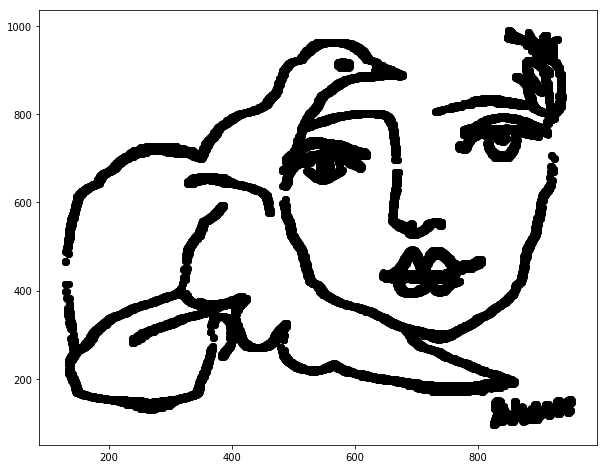

In [101]:
xs,ys = interp_image(face)
plt.figure(figsize = (10,8))
plt.scatter(xs,ys,color='k')
plt.show()

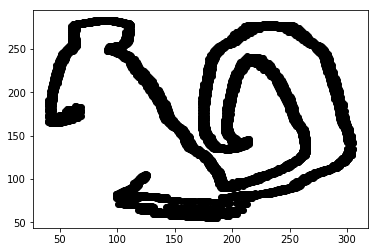

In [103]:
squirrel = imageio.imread('Paintings/Squirrel_Picasso.jpg')
#plt.figure(figsize = (10,8))
xs,ys = interp_image(squirrel)
plt.scatter(xs,ys,color='k')
plt.show()

It works! On an unseen image! Amazing!